# Proyecto Bedu - Análisis de casos de derrame cerebral

Autor: Eduardo González López

**Predicción de derrame cerebral**

De acuerdo a la Organización Mundial de la Salud (OMS), el derrame cerebral es la segunda causa a nivel mundial de muerte contando con un total del 11% de las muertes totales. Por lo que es de suma importancia preever mediante una predicción estadística cuando un paciente sufra un derrame cerebral.

Para ello se dispone de este dataset con información clínica como edad, género, hipertensión, problemas de corazón, y más, de pacientes que sufieron y no sufrieron un derrame cerebral. 

El dataset fue obtenido de la página web [Kaggle](https://www.kaggle.com/fedesoriano/stroke-prediction-dataset). 

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import skew, kurtosis
import math
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

sns.set_style("dark")

# Limpieza y preparación de datos

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Bedu/healthcare-dataset-stroke-data.csv")
df.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


Se observan 5,110 registros de pacientes, de los cuales 201 no cuentan con indice de masa corporal. Se sospecha que los datos faltantes se deben a un error de captura, por lo que se decide eliminar a esos 201 pacientes para tener una análisis de muestra más confiable. 

In [ ]:
print(df.isna().sum())
df.dropna(inplace=True)

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


# Estimados de locación y variabilidad 
# Distribuciones

Las variables numéricas que se identifican son: 


1.   Nivel de glucosa promedio
2.   Indice de masa corporal
3.   Edad

Por lo que se decide explorar un diagramas de cajas para observar la distribución de los datos e identificar anomalías.

## Funciones

In [ ]:
# Función para variables numéricas
def reporteCuan(column):
  print("### Reporte de estimadores de tendencia central ###")
  print(f'Media: {round(column.mean(),2)}')
  print(f'Moda: {column.mode()[0]}')
  print(f'Desv. Estándar: {round(column.std(),2)}')
  print("\n### Reporte de cuantiles ###")
  print(f'Mínimo: {column.min()}')
  print(f'1er. Cuartil: {column.quantile(0.25)}')
  print(f'Mediana: {column.median()}')
  print(f'3er. Cuartil: {column.quantile(0.75)}')
  print(f'Máximo: {column.max()}')
  print("\n### Reporte de rangos ###")
  print(f'Rango: {column.max()-column.min()}')
  print(f'RIQ: {column.quantile(0.75)-column.quantile(0.25)}')
  print("\n### Reporte de distribución ###")
  print(f'Curtosis: {round(kurtosis(column),2)}')
  print(f'Asimetría: {round(skew(column),2)}')
  print("\n Asimetría")
  if(skew(column) > 0):
    print("Distribución sesgada a la izquierda")
  elif(skew(column) < 0):
    print("Distribución sesgada a la derecha")
  else:
    print("Distribución simétrica")
  print("\n Curtosis")
  if(kurtosis(column) > 0):
    print("Alta concentración hacia la media")
  elif(kurtosis(column) < 0):
    print("Baja concentración hacia la media")
  else:
    print("Concentracón normal hacia la media")
  if( (math.floor(column.mean()) == math.floor(column.median())) & (math.floor(column.mean()) == math.floor(column.mode()[0])) ):
    print("\n Se propone que la distribución es normal debido a tener media, mediana y moda igual")
  else:
    pass


In [ ]:
# Grafica de variables numéricas... style = ["count", "density", "frequency", "probability"] - reporte [True, False]
def graficas(column, name, style, reporte):
  fig, axs = plt.subplots(2, figsize=(6,5))

  fig.suptitle("Diagrama de caja e histograma", fontsize = 14)
  box = sns.boxplot(x = column, ax = axs[0])
  box.set(xlabel = None)
  hist = sns.histplot(x = column, ax = axs[1], stat = style)
  hist.set_ylabel(style)
  plt.xlabel(name, fontsize = 14)
  if reporte == True:
    reporteCuan(column)
  else:
    pass

In [ ]:
# Filtro anomalias
def filtro_anomalias(column,tol):
  IQR = column.quantile(0.75) - column.quantile(0.25)
  filtro_superior = column < column.quantile(0.75) + (IQR*tol)
  filtro_inferior = column > column.quantile(0.25) - (IQR*tol)

  return column[filtro_inferior & filtro_superior]

def graficas_anomalias(column,tol, name, 
                       style = 'frequency', reporte = 1):
  fig, axs = plt.subplots(2, figsize=(6,5))
  X = filtro_anomalias(column, tol)

  fig.suptitle("Diagrama de caja e histograma sin anomalias", fontsize = 14)
  box = sns.boxplot(x=X)
  box.set(xlabel = None)
  hist = sns.histplot(x=X, ax = axs[1], stat = style)
  hist.set_ylabel(style)
  plt.xlabel(name, fontsize = 14)
  box.set_title(name, fontsize = 14)
  if reporte == True:
    reporteCuan(column)
  else:
    pass

## Variables numéricas

**Nivel promedio de glucosa**

Se observan anomalías que exceden el 1.5(IQR) predeterminado de la funcion boxplot de seaborn. Sin embargo, existen varias busquedas en internet que afirman que existe una relacion entre el nivel de glucosa y los derrames cerebrales, por lo cual **se decide mantener las anomalias**. 

[Fuente 1](https://www.niddk.nih.gov/health-information/informacion-de-la-salud/diabetes/informacion-general/prevenir-problemas/diabetes-enfermedad-corazon-ataques-cerebrales), [Fuente 2](http://archives.diabetes.org/es/vivir-con-diabetes/complicaciones/enfermedades-del-corazon/derrame-cerebral.html)

### Reporte de estimadores de tendencia central ###
Media: 105.31
Moda: 93.88
Desv. Estándar: 44.42

### Reporte de cuantiles ###
Mínimo: 55.12
1er. Cuartil: 77.07
Mediana: 91.68
3er. Cuartil: 113.57
Máximo: 271.74

### Reporte de rangos ###
Rango: 216.62
RIQ: 36.5

### Reporte de distribución ###
Curtosis: 1.9
Asimetría: 1.61

 Asimetría
Distribución sesgada a la izquierda

 Curtosis
Alta concentración hacia la media


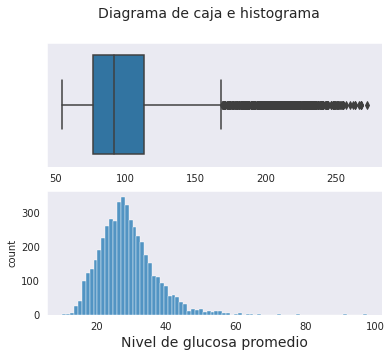

In [ ]:
graficas(df.avg_glucose_level, "Nivel de glucosa promedio", "count",1)

**Bootstrap del Nivel de glucosa promedio**

In [ ]:
meansGlucose = [df.avg_glucose_level.sample(replace = True).mean() for i in range (100_000)]

La media muestral estimada del nivel de glucosa promedio es de 105, con un intervalo de confianza del 95% de (104,107)


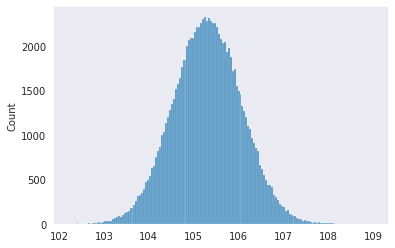

In [ ]:
meansGlucose = pd.Series(meansGlucose)
sns.histplot(x = meansGlucose);
print(f'La media muestral estimada del nivel de glucosa promedio es de {round(meansGlucose.mean())}'
f', con un intervalo de confianza del 95% de ({round(meansGlucose.quantile(0.025))},{round(meansGlucose.quantile(0.975))})')

**Índice de Masa Corporal (IMC)**

Al igual que la glucosa existe anomalias, sin embargo, se mantienen los datos debido a que el sobrepeso y la obesidad tienen una relacion con casos de derrame cerebral.

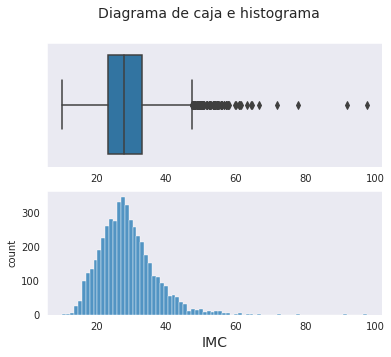

In [ ]:
graficas(df.bmi, "IMC", "count",0)

**Bootstrap de IMC**

In [ ]:
meansImc = [df.bmi.sample(frac = 0.7 , replace = True).mean() for i in range (100_000)]

La media muestral estimada de IMC es de 29, con un intervalo de confianza del 95% de (29,29)


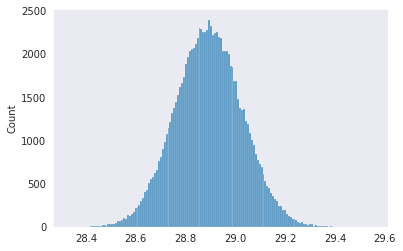

In [ ]:
meansImc = pd.Series(meansImc)
sns.histplot(x = meansImc);
print(f'La media muestral estimada de IMC es de {round(meansImc.mean())}'
f', con un intervalo de confianza del 95% de ({round(meansImc.quantile(0.025))},{round(meansImc.quantile(0.975))})')

**Edad**

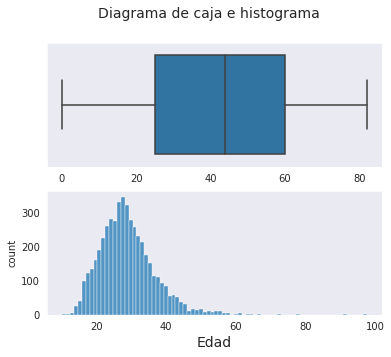

In [ ]:
graficas(df.age, "Edad", "count", 0)

**Bootstrap de edades**


In [ ]:
meansAge = [df.age.sample(frac = 0.7 , replace = True).mean() for i in range (100_000)]

La media muestral estimada de edad es de 43 años, con un intervalo de confianza del 95% de (42,44)


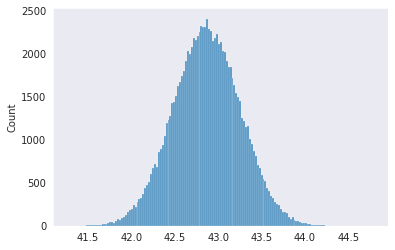

In [ ]:
meansAge = pd.Series(meansAge)
sns.histplot(x = meansAge);
print(f'La media muestral estimada de edad es de {round(meansAge.mean())} años'
f', con un intervalo de confianza del 95% de ({round(meansAge.quantile(0.025))},{round(meansAge.quantile(0.975))})')

# Exploracion de variables categoricas y numericas agrupadas por derrame cerebral

Variables significantes:


*   Edad
*   Nivel de glucosa



## Funciones

In [ ]:
# Grafica de barras horizontales
def barras(column, style, name):
  counts = column.value_counts()
  if(style == '%'):
    bar  = sns.barplot(y = counts.index, x = (counts*100)/counts.sum(), orient = 'h', palette= 'rocket')
    plt.xlabel('Porcentaje', fontsize = 16)
    for p in bar.patches:
      width = p.get_width()    # get bar length
      bar.text(width,       # set the text at 1 unit right of the bar
              p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
              '{:1.2f}%'.format(width), # set variable to display, 2 decimals
              ha = 'left',   # horizontal alignment
              va = 'center')  # vertical alignment 
  else:
    bar  = sns.barplot(y = counts.index, x = counts, orient = 'h', palette = 'rocket')
    plt.xlabel(xlabel = 'count', fontsize = 16)
    for p in bar.patches:
      width = p.get_width()    # get bar length
      bar.text(width,       # set the text at 1 unit right of the bar
              p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
              '{:1}'.format(width), # set variable to display, 2 decimals
              ha = 'left',   # horizontal alignment
              va = 'center')  # vertical alignment
  bar.set_title('Grafica de barras', fontsize = 18)
  plt.ylabel(name, fontsize = 14)

In [ ]:
# Grafica de mapa de calor
def tabContigencia(columnA, columnB, style, names):
  cross = pd.crosstab(columnA, columnB)
  if(style == '%'):
    heat = sns.heatmap(cross*100/cross.values.sum(), cmap = 'rocket_r', fmt = 'g', annot = True, linewidths= 0.5)
    heat.set_title('Mapa de calor (%)', fontsize = 16)
  else:
    heat = sns.heatmap(cross, cmap = 'rocket_r', fmt = 'g', annot = True, linewidths= 0.5)
    heat.set_title('Mapa de calor', fontsize = 16)
  heat.set_xlabel(names[0], fontsize = 14)
  heat.set_ylabel(names[1], fontsize = 14)

In [ ]:
# Grafica de violin y diagrama de cajas
def viobox(data,numeric,index,category, style):
  byId = data.groupby(level = 0)[numeric].mean()
  cat = data.groupby(level = 0)[category].last()
  merged = byId.merge(cat, left_index= True, right_index= True)
  if(style == 'box'):
    ax = sns.boxplot(data=merged, x=category, y=numeric[index])
    ax.set_title('Diagrama de cajas', fontsize = 14)
  elif(style == 'vio'):
    ax = sns.violinplot(data = merged, x = category, y = numeric[index])
    ax.set_title('Diagrama de violines', fontsize = 14)

## Variables categoricas

**Derrame cerebral******

Se cueta con un 4% de casos con derrame cerebral, lo cual puede dificultar el poder de prediccion del modelo.

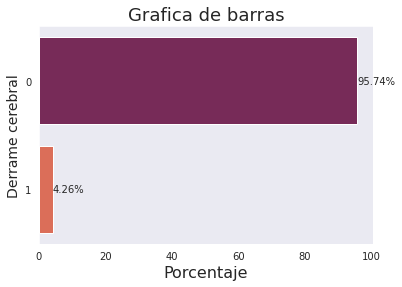

In [ ]:
barras(df.stroke, '%', 'Derrame cerebral')

**Fumadores****** 

De una tercera parte de los pacientes de desconoce si sin fumadores o no, por lo que sera importante considerarlo en el momento de modelar. Sin embargo, queda claro que eliminar los datos no es una opcion viable debido a que se perderia informacion valiosa. 

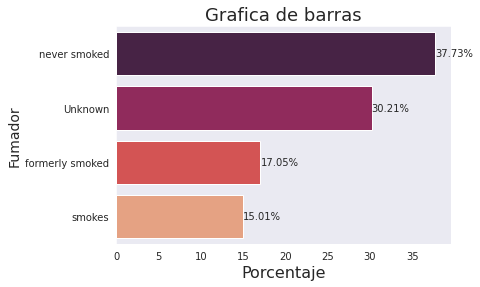

In [ ]:
barras(df.smoking_status, '%', 'Fumador')

**Problemas de corazon e hipertension*******

Un 87% de los pacientes no padecen problemas de corazon ni hipertension.

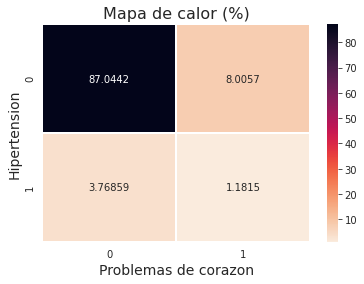

In [ ]:
tabContigencia(df.heart_disease, df.hypertension, '%' ,['Problemas de corazon', 'Hipertension'])

**Tipo de residencia**

Se distribuyen 50/50 los tipos de residencia de los pacientes. 

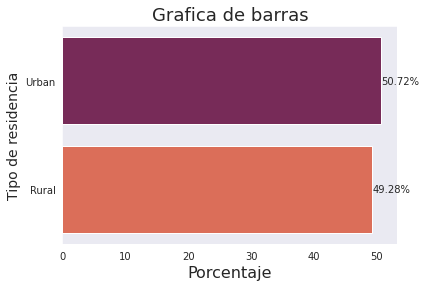

In [ ]:
barras(df.Residence_type, '%', 'Tipo de residencia')

**Casados**


Casi 2/3 de los pacientes se encuentran casados. 

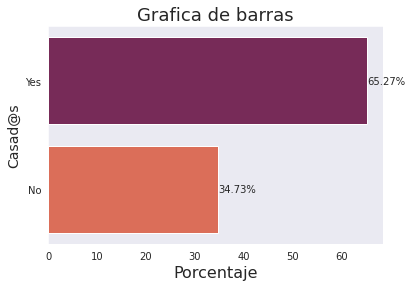

In [ ]:
barras(df.ever_married, '%', 'Casad@s')

**Tipo de trabajo**



Los porcentajes de tipos de trabajo aparentan no ser relevantes

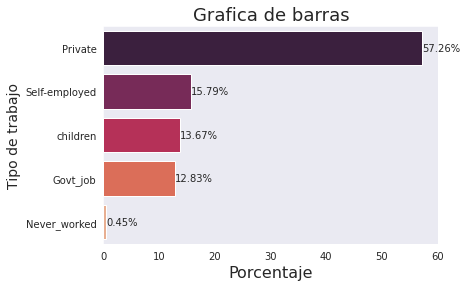

In [ ]:
barras(df.work_type, '%', 'Tipo de trabajo')

##  Boxplot & violinplots para derrame cerebral

*   Edad: La mayoria de los que sufren derrame cerebral se concentran en los 80 anios
*   IMC: No muestra diferencia entre grupos
*   Nivel de glucosa: Los que sufren derrame cerebral muestran dos modas

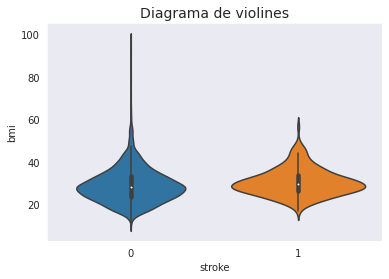

In [ ]:
# 0 = age, 1 =  bmi, 2 = avg glucose level 
# box = boxplot, vio = violinplot
viobox(df, ['age', 'bmi', 'avg_glucose_level'], 1 ,'stroke', 'vio')

# Correlaciones y regresiones simples

No fue posible identificar correlaciones por encima de 0.4 entre las variables ni tampoco modelar una regresión lineal con buen score

In [ ]:
dfCorrelations = df.drop(columns = ['id', 'work_type', 'Residence_type', 'smoking_status', 
                                    'stroke', 'heart_disease', 'hypertension', 'ever_married'])

**Mapa de correlaciones**

No se identifican correlaciones lineales fuertes entre las variables numericas

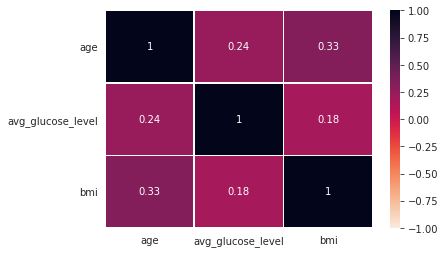

In [ ]:
sns.heatmap(dfCorrelations.corr(), vmin = -1, vmax = 1, annot = True, cmap = 'rocket_r', linewidths= 0.5);

**Regresion lineal multiple**

Se propone un modelo de regresion lineal multiple con variables numericas y dummies para identificar si son capaces de ajustarse en prediccion de los derrames cerebrales

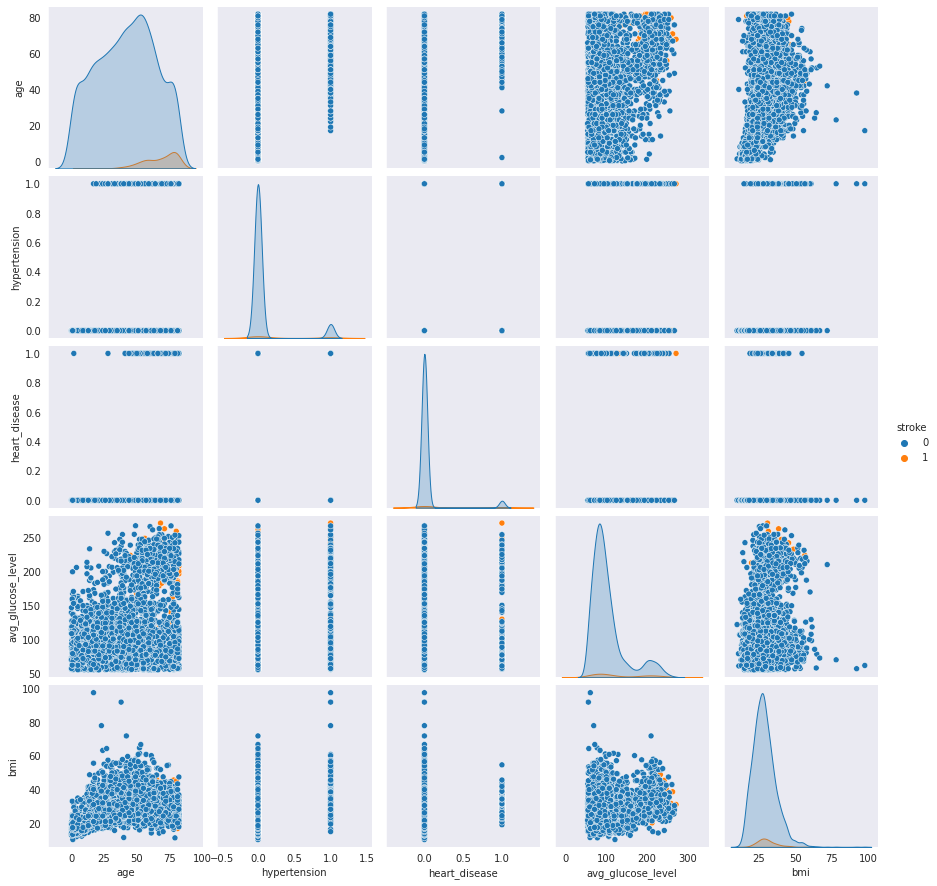

In [ ]:
dfRegression = df.drop(columns = ['id', 'work_type', 'Residence_type', 'smoking_status', 'gender', 'ever_married'])
sns.pairplot(dfRegression, hue = 'stroke');

In [ ]:
X = dfRegression.drop(columns = ['stroke'])
y = dfRegression['stroke']

In [ ]:
lr = LinearRegression()

scores = cross_validate(lr, X, y, scoring='r2')

**Scores**

Como se esperaba la validacion cruzada no muestra una relacion lineal entre las variables

In [ ]:
print(f'Score del modelo: {scores["test_score"].mean():.2f} +/- {scores["test_score"].std():.2f}')

Score del modelo: -0.054 +/- 0.108


# Pruebas de hipotesis

Varibles significantes:
*   Hypertension
*   Heart disease

## Funciones

In [ ]:
def AB(data, colname,n):
  pd.options.mode.chained_assignment = None
  data["noStroke"] = data["stroke"]

  for i in range(data.shape[0]):
    if data["stroke"][i] == 1:
      data["noStroke"][i] = 0
    else:
      data["noStroke"][i] = 1
  
  test = df.groupby(colname)[['stroke',"noStroke"]].sum()
  test["success"] = test["stroke"] / (test["stroke"] + test["noStroke"])

  A = df[colname].unique()[0]
  B = df[colname].unique()[1]

  conv_a = []
  no_conv_a = []
  conv_b = []
  no_conv_b = []

  for _ in range(n):
      if A == 0:
        a = df.sample(df[colname].value_counts().loc[A], replace=False)
      else:
        a = df.sample(df[colname].value_counts().loc[B], replace=False)
      conv_a.append(a['stroke'].sum())
      no_conv_a.append(a['noStroke'].sum())
      
      b = df.loc[~df.index.isin(a.index)]
      conv_b.append(b['stroke'].sum())
      no_conv_b.append(b['noStroke'].sum())
  
  perm_results = pd.DataFrame({
    'conv_a': conv_a,
    'no_conv_a': no_conv_a,
    'conv_b': conv_b,
    'no_conv_b': no_conv_b
  })

  perm_results['a_conv_rate'] = perm_results['conv_a'] / (perm_results['conv_a'] + perm_results['no_conv_a'])
  perm_results['b_conv_rate'] = perm_results['conv_b'] / (perm_results['conv_b'] + perm_results['no_conv_b'])

  perm_results['diff'] = (perm_results['b_conv_rate'] / perm_results['a_conv_rate']) - 1

  if A == 0:
    diferenciaProporcion = (test.loc[A]["success"] / test.loc[B]["success"]) - 1
  else:
    diferenciaProporcion = (test.loc[B]["success"] / test.loc[A]["success"]) - 1
  
  print(f'Varible A: {A}')
  print(f'Varible B: {B}')
  print((perm_results['diff'] >= diferenciaProporcion).sum() / perm_results.shape[0])
  
  hist = sns.histplot(x=perm_results['diff'])
  hist.set_title(f'Prueba de hipotesis A/B: {colname}')
  plt.axvline(diferenciaProporcion)

## Pruebas

Varible A: Male
Varible B: Female
0.717


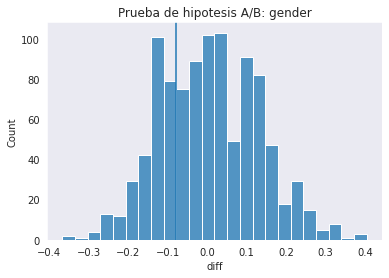

In [ ]:
AB(df, "gender", 1_000)

Varible A: 0
Varible B: 1
1.0


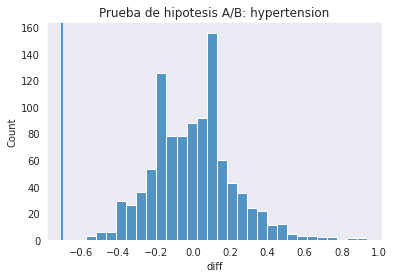

In [ ]:
AB(df, "hypertension", 1_000)

Varible A: 1
Varible B: 0
0.998


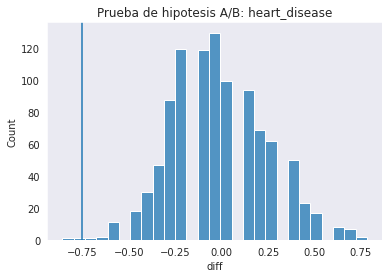

In [ ]:
AB(df, "heart_disease", 1_000)

Varible A: Urban
Varible B: Rural
0.882


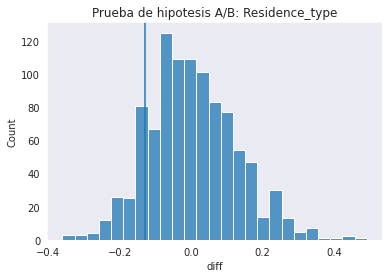

In [ ]:
AB(df, "Residence_type", 1_000)

# Logistic regression

In [ ]:
dfLogistic = df.drop(columns = ["id","ever_married", "smoking_status", "bmi", "work_type", "gender", "Residence_type"])
dfLogistic.head()

,age,hypertension,heart_disease,avg_glucose_level,stroke
0,67.0,0,1,228.69,1
2,80.0,0,1,105.92,1
3,49.0,0,0,171.23,1
4,79.0,1,0,174.12,1
5,81.0,0,0,186.21,1


In [ ]:
X = dfLogistic.drop(columns = ["stroke"])
y = dfLogistic["stroke"]

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [ ]:
logreg = LogisticRegression()

logreg.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
logreg.score(X_test, y_test)

0.9599456890699253

## Borrador

In [ ]:
y_pred = logreg.predict(X_test)

y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [ ]:
y_pred_proba = logreg.predict_proba(X_test)

y_pred_proba[:10,:]

array([[0.97789134, 0.02210866],
       [0.97888363, 0.02111637],
       [0.88309444, 0.11690556],
       [0.87803429, 0.12196571],
       [0.95845245, 0.04154755],
       [0.97127154, 0.02872846],
       [0.99412263, 0.00587737],
       [0.97363351, 0.02636649],
       [0.99308175, 0.00691825],
       [0.69362826, 0.30637174]])

In [ ]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
roc_auc = auc(fpr, tpr)

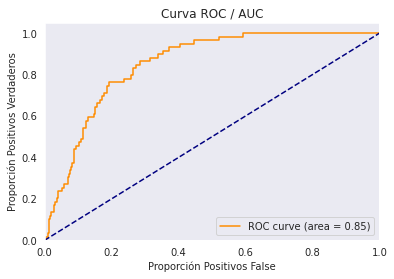

In [ ]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Proporción Positivos False')
plt.ylabel('Proporción Positivos Verdaderos')
plt.title('Curva ROC / AUC')
plt.legend(loc="lower right")
plt.show()
# balance acuraccy

# REGEX

FIFA World Cup 2018 Tweets from [Kaggle](https://www.kaggle.com/rgupta09/world-cup-2018-tweets)

In [ ]:
import nltk
from nltk.corpus import stopwords


In [ ]:
df2 = pd.read_csv("/content/drive/MyDrive/Bedu/FIFA.csv")
df2.head()

,ID,lang,Date,Source,len,Orig_Tweet,Tweet,Likes,RTs,Hashtags,UserMentionNames,UserMentionID,Name,Place,Followers,Friends
0,1013597060640145408,en,2018-07-02 01:35:45,Twitter for Android,140,RT @Squawka: Only two goalkeepers have saved t...,Only two goalkeepers have saved three penaltie...,0,477,"WorldCup,POR,ENG",Squawka Football,Squawka,Cayleb,Accra,861,828
1,1013597056219295744,en,2018-07-02 01:35:44,Twitter for Android,139,RT @FCBarcelona: ?? @ivanrakitic scores the wi...,scores the winning penalty to send into the qu...,0,1031,WorldCup,"FC Barcelona,Ivan Rakitic,HNS | CFF","FCBarcelona,ivanrakitic,HNS_CFF",Febri Aditya,Bogor,667,686
2,1013597047482544130,en,2018-07-02 01:35:42,Twitter for Android,107,RT @javierfernandez: Tonight we have big game....,Tonight we have big game,0,488,worldcup,"Javier Fernandez,Evgeni Plushenko","javierfernandez,EvgeniPlushenko",??,NaN,65,67
3,1013597044198391808,en,2018-07-02 01:35:41,Twitter Web Client,142,We get stronger\r\nTurn the music up now\r\nWe...,We get stronger Turn the music up now We got t...,0,0,"PowerByEXO,WorldCup,FIFAStadiumDJ,XiuminLeague","EXO,FIFA World Cup ?","weareoneEXO,FIFAWorldCup",Frida Carrillo,"Zapopan, Jalisco",17,89
4,1013597039999926272,en,2018-07-02 01:35:40,Twitter for Android,140,RT @Squawka: Only two goalkeepers have saved t...,Only two goalkeepers have saved three penaltie...,0,477,"WorldCup,POR,ENG",Squawka Football,Squawka,tar,NaN,137,216


In [ ]:
df2 = df2.dropna()

In [ ]:
df2 = df2.loc[df2['Name'].str.contains(r'[@#&$%+-/*?™®¡!€ø|‘—•<›“÷>„†"]') == False]


In [ ]:
df2.Name = df2.Name.str.replace('[^\w\s]', '')
df2.Name = df2.Name.str.replace('\d', '')
df2.Name = df2.Name.str.replace('\\n', '')

In [ ]:
grouped = df2.groupby("Name")["Tweet"].last()
grouped

Name
             Dear France Congratulations on winning the of ...
A            Dear France Congratulations on winning the of ...
AA           Dear France Congratulations on winning the of ...
AAAdams      Pure drama Despite Kasper Schmeichels heroics ...
AADEESH                                   Leo Messi leaves the
                                   ...                        
ódògwu       THIEF This woman at the World Cup trophy prese...
ögee         Big blonde angry Dane lets one too many balls ...
öyxñdä              adidas Golden Glove Award Thibaut COURTOIS
üsmänov      Kasper Schmeichel takes the final award of the...
šparavalo    CROATIA IS LEVEL Its Peri who manages to put t...
Name: Tweet, Length: 36954, dtype: object

In [ ]:
grouped = grouped.dropna()
grouped = grouped.str.replace('[^\w\s]', '')
grouped = grouped.str.replace('\d', '')
grouped = grouped.str.replace('\\n', '')

In [ ]:
grouped[grouped.str.contains("\sspain\s|\sfair\s", case=False, na=False)]

Name
ACS__                            FIFA Fair Play Trophy Spain
ADANALI                                 Wow Spain are out of
ADITYA                           FIFA Fair Play Trophy Spain
AJIM                             FIFA Fair Play Trophy Spain
ALEJOSO                          FIFA Fair Play Trophy Spain
                                 ...                        
zami       Golo Kante is winner Proof that life is fair a...
zara       Awww Ronaldo so cute and fair play helping Cavani
zude        Russians celebrating their win over Spain in the
ÆDAM       Retweet if your country are still in the Russi...
Índia      Awww Ronaldo so cute and fair play helping Cavani
Name: Tweet, Length: 538, dtype: object

In [ ]:
tokenized = grouped.apply(nltk.word_tokenize)

In [ ]:
all_words = tokenized.sum()

In [ ]:
english_stop_words = stopwords.words('english')

all_words_except_stop_words = [word for word in all_words if word not in english_stop_words]

freq_dist_no_stop_words = nltk.FreqDist(all_words_except_stop_words)

In [ ]:
freq_dist_no_stop_words.most_common(50)

[('France', 7795),
 ('Congratulations', 4899),
 ('team', 3961),
 ('African', 3278),
 ('winning', 3250),
 ('Dear', 2774),
 ('cut', 2757),
 ('racism', 2756),
 ('xenophobi', 2746),
 ('FIFA', 2739),
 ('The', 2724),
 ('final', 2543),
 ('Golden', 1734),
 ('Cup', 1658),
 ('World', 1602),
 ('Russia', 1564),
 ('win', 1494),
 ('So', 1310),
 ('Moscow', 1249),
 ('Croatia', 1239),
 ('Kylian', 1236),
 ('immigrants', 1231),
 ('What', 1080),
 ('Award', 1062),
 ('Messi', 1053),
 ('player', 1048),
 ('best', 1039),
 ('players', 1005),
 ('Argentina', 945),
 ('We', 934),
 ('first', 922),
 ('teams', 914),
 ('This', 865),
 ('time', 865),
 ('England', 862),
 ('finals', 837),
 ('Mbappe', 834),
 ('fans', 832),
 ('game', 823),
 ('one', 822),
 ('day', 800),
 ('From', 785),
 ('You', 782),
 ('football', 772),
 ('Glove', 744),
 ('quarter', 736),
 ('Player', 717),
 ('vs', 704),
 ('Thibaut', 692),
 ('great', 692)]

In [ ]:
print(f'{(100 * freq_dist_no_stop_words["France"] / len(all_words_except_stop_words)):.3f}%')

3.100%


In [ ]:
len(all_words_except_stop_words)

251484

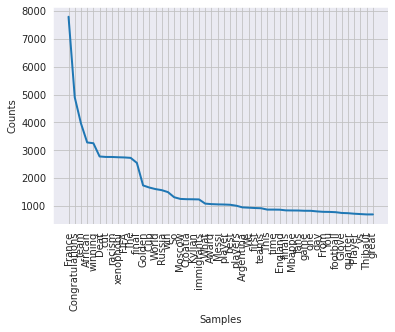

In [ ]:
freq_dist_no_stop_words.plot(50, cumulative=False);

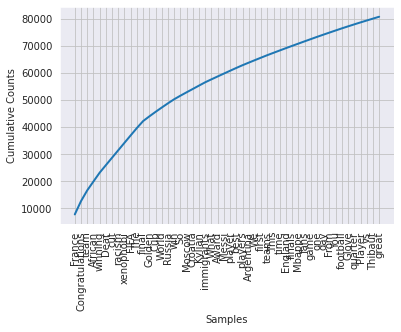

In [ ]:
freq_dist_no_stop_words.plot(50, cumulative=True);

In [ ]:
freq_dist_no_stop_words.hapaxes()[:20]

['portugal',
 'TY',
 'cultural',
 'melt',
 'seventh',
 'Barnes',
 'drops',
 'bars',
 'Late',
 'scheduling',
 'AFTN',
 'briefly',
 'interviews',
 'Kendall',
 'Waston',
 'Dale',
 'Mitchell',
 'FM',
 'Turrell',
 'Saunders']